In [1]:
from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table

import mapper_KV450
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)

bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [3]:
path = '/home/zcapjru/PhD/Data/KV450/'

cats = [path+'KV450_G12_reweight_3x4x4_v2_good.cat', 
        path+'KV450_G23_reweight_3x4x4_v2_good.cat',
        path+'KV450_GS_reweight_3x4x4_v2_good.cat',
        path+'KV450_G15_reweight_3x4x4_v2_good.cat',
        path+'KV450_G9_reweight_3x4x4_v2_good.cat'
       ]
cats

['/home/zcapjru/PhD/Data/KV450/KV450_G12_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G23_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_GS_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G15_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G9_reweight_3x4x4_v2_good.cat']

In [4]:
KV_1_config = {'data_catalogs': cats , 
                'file_nz':path + 'REDSHIFT_DISTRIBUTIONS/Nz_DIR/Nz_DIR_Mean/Nz_DIR_z0.1t0.3.asc',
          'zbin':1,
          'nside':nside, 
          'mask_name': 'mask_KV450_1'}

KV_2_config = {'data_catalogs': cats ,               
                'file_nz':path + 'REDSHIFT_DISTRIBUTIONS/Nz_DIR/Nz_DIR_Mean/Nz_DIR_z0.3t0.5.asc',
          'zbin':2,
           'mask_name': 'mask_KV450_2',
          'nside':nside }

In [5]:
column_names = ['SG_FLAG', 'GAAP_Flag_ugriZYJHKs',
                             'Z_B', 'Z_B_MIN', 'Z_B_MAX',
                             'ALPHA_J2000', 'DELTA_J2000', 'PSF_e1', 'PSF_e2',
                             'bias_corrected_e1', 'bias_corrected_e2',
                             'weight']
        
zbin_edges = {
        '1':[0.1, 1.2],
        '2':[0.3, 0.5],
        '3':[0.5, 0.7],
        '4':[0.7, 0.9],
        '5':[0.9, 1.2]}
        
cat_data = []
print('loading full cats and making lite versions')
for i, file_data in enumerate(cats):
    if not os.path.isfile(file_data):
        raise ValueError(f"File {file_data} not found")
    with fits.open(file_data) as f:
        table = Table.read(f)[column_names] #.to_pandas()[self.column_names] 
        #table.to_pickle('DES_lite_cat_{}.pkl'.format(i))
        cat_data.append(table)

loading full cats and making lite versions


In [6]:
from astropy.table import vstack
cat = vstack(cat_data)
print(len(cat))

sel = cat['SG_FLAG'] == 1
cat = cat[sel]
print(len(cat))

cat1 = cat[(cat['Z_B'] >= 0.1) &
                   (cat['Z_B'] <0.3)]
cat2 = cat[(cat['Z_B'] >= 0.3) &
                   (cat['Z_B'] <0.5)]
cat3 = cat[(cat['Z_B'] >= 0.5) &
                   (cat['Z_B'] <0.7)]
cat4 = cat[(cat['Z_B'] >= 0.7) &
                   (cat['Z_B'] <0.9)]
cat5 = cat[(cat['Z_B'] >= 0.9) &
                   (cat['Z_B'] <1.2)]
print(len(cat1), len(cat2), len(cat3), len(cat4), len(cat5) )
print(len(cat1)+ len(cat2)+len(cat3)+len(cat4)+len(cat5) )



14221082
14210251
1019490 1836390 3800238 2848375 2889112
12393605


In [7]:
len(cat['ALPHA_J2000'])

14210251

In [8]:
KV_1_maps = mapper_KV450.MapperKV450(KV_1_config)
#KV_2_maps = mapper_KV450.MapperKV450(KV_2_config)

loading lite cats
Catalogs loaded
z edges  [0.1, 1.2]
data concatenated
Length of galaxies:  12393605
Length of stars:  9319
Data binned


/home/zcapjru/PhD/DEScls/mappers/mapper_KV450.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cat_data[sel_gals]['bias_corrected_e1'] -= np.mean(self.cat_data[sel_gals]['bias_corrected_e1'])
/home/zcapjru/PhD/DEScls/mappers/mapper_KV450.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cat_data[sel_gals]['bias_corrected_e2'] -= np.mean(self.cat_data[sel_gals]['bias_corrected_e2'])


Additive biased removed


/home/zcapjru/PhD/DEScls/mappers/mapper_KV450.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cat_data[sel_gals]['bias_corrected_e1'] /= 1 + m[self.zbin]


Multiplicative bias removed


/home/zcapjru/PhD/DEScls/mappers/mapper_KV450.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cat_data[sel_gals]['bias_corrected_e2'] /= 1 + m[self.zbin]


In [9]:
len(KV_1_maps.cat_data) #12 402 924 as opposed to  11 926 455

12402924

In [10]:
KV_nz_1 = KV_1_maps.dndz
KV_z_1 = KV_nz_1[0]
KV_dNdz_1 = KV_nz_1[1]

#DES_nz_2 = DES_2_maps.get_nz()
#DES_z_2 = DES_nz_2[0]
#DES_dNdz_2 = DES_nz_2[1]

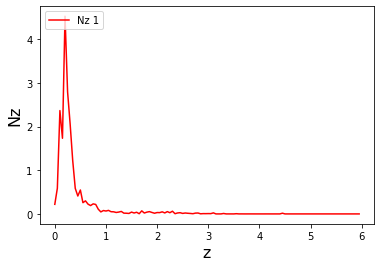

In [11]:
plt.plot(KV_z_1, KV_dNdz_1, 'r-', label='Nz 1')
#plt.plot(DES_z_1, DES_dNdz_1, 'g-', label='Nz 2')

plt.xlabel('z', fontsize=16)
plt.ylabel('Nz', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()

In [12]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
KV_shear = ccl.CMBLensingTracer(cosmo, 0.6)
KV_theory = ccl.angular_cl(cosmo, KV_shear, KV_shear, ell_arr) 

In [13]:
KV_1_shear       = KV_1_maps.get_shear_map()

In [14]:
KV_1_galaxys     = KV_1_maps.get_psf_map()

In [15]:
KV_1_stars       = KV_1_maps.get_star_map()

In [16]:
KV_1_star_mask   = KV_1_maps.get_star_mask()

In [17]:
KV_1_galaxy_mask = KV_1_maps.get_galaxy_mask()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

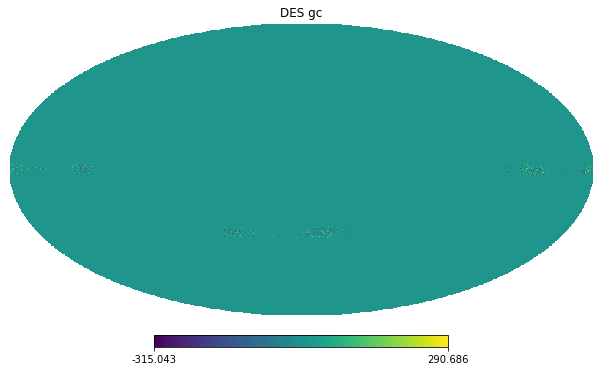

In [18]:
hp.visufunc.mollview(KV_1_shear[1], title= 'DES gc')

In [19]:
DES_f_1 =  DES_1_maps.get_nmt_field()
DES_f_2 =  DES_2_maps.get_nmt_field()

NameError: name 'DES_1_maps' is not defined

In [ ]:
DES_w_11 = nmt.NmtWorkspace()
DES_w_11.compute_coupling_matrix(DES_f_1, DES_f_1, bands)

DES_w_12 = nmt.NmtWorkspace()
DES_w_12.compute_coupling_matrix(DES_f_1, DES_f_2, bands)

In [ ]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [ ]:
def load_carlos_cl(a, b):
    return np.load('/home/zcapjru/PhD/Data/DESgc_carlos/cl_DESgc{}_DESgc{}.npz'.format(a,b))

In [ ]:
DES_nl_11 = DES_w_11.decouple_cell(DES_1_maps.get_nl_coupled())
cl_11 = compute_cl(DES_f_1, DES_f_1, DES_w_11)
cl_11 = cl_11 - DES_nl_11
ccl_11 = load_carlos_cl(0,0)

In [ ]:
cl_12 = compute_cl(DES_f_1, DES_f_2, DES_w_12)
ccl_12 = load_carlos_cl(0,1)

In [ ]:
plt.plot(ell_arr, cl_11[0], 'r-', label='Jaime cl_ij')
plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DES gc Cl 11')
plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(ell_arr, cl_12[0], 'r-', label='Jaime cl_ij')
plt.plot(ell_arr, DES_theory_12, 'r--', label='Theory cl_ij')
plt.plot(ccl_11['ell'], ccl_12['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DES gc Cl 12')
plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

## Checking with Carlos 

In [ ]:
def load_cl(a, b):
    return np.loadtxt('/home/zcapjru/PhD/Data/get_4096/DES_cl_{}{}.txt'.format(a,b))

In [ ]:
nside = 4096

ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    i = i+20*(1+i/500)
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [ ]:
cl_11 = load_cl(0,0)
cl_12 = load_cl(0,1)
ccl_11 = load_carlos_cl(0,0)
ccl_12 = load_carlos_cl(0,1)


In [ ]:
print(ccl_11['ell'], ccl_11['cl'])
print(cl_11)

In [ ]:
#plt.plot( cl_11, 'r-', label='Jaime cl_ij')
plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('Quasars density angular power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()